In [110]:
import pickle
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM
from keras.models import Sequential, Model
from tensorflow.keras.layers import TextVectorization

In [63]:
with open('.venv/ChatBot (NLP)/train_qa.txt', 'rb') as handle:
    train_data = pickle.load(handle)

In [64]:
with open('.venv/ChatBot (NLP)/test_qa.txt', 'rb') as handle:
    test_data = pickle.load(handle)

In [65]:
all_data = test_data + train_data

In [66]:
vocab = set()

In [67]:
train_story_text = []
train_question_text = []
train_answers = []

In [68]:
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
    train_story_text.append(story)
    train_question_text.append(question)

In [69]:
vocab.add('no')

In [70]:
vocab.add('yes')

In [71]:
vocab_len = len(vocab) + 1

In [72]:
vocab_len

38

In [73]:
vocab_len = len(vocab) + 1  # for padding
max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])

In [74]:
def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    cleaned_text = tf.strings.regex_replace(lowercase, '[%s]' % re.escape('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'), '')
    return cleaned_text

In [76]:
# Convert vocab set to a list
vocab_list = list(vocab)

# Text vectorization
vectorizer = TextVectorization(output_sequence_length=max_story_len, standardize=custom_standardization)

# Use the adapted list
vectorizer.adapt(vocab_list)


In [175]:
# Updated vectorize_stories function to pass single string to vectorizer
def vectorize_stories(data, vectorizer, max_story_len=max_story_len, max_question_len=max_question_len):
    '''
    INPUT:
    data: consisting of Stories, Queries, and Answers
    vectorizer: TextVectorization layer for encoding words
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)
    
    OUTPUT:
    Vectorizes the stories, questions, and answers into padded sequences.
    '''
    X = []   # Stories
    Xq = []  # Questions
    Y = []   # Answers

    for story, query, answer in data:
        # Convert story and query to single strings
        story_str = ' '.join(story)
        query_str = ' '.join(query)

        # Vectorize the story and query using the vectorizer
        x = vectorizer(np.array([story_str]))[0].numpy()
        xq = vectorizer(np.array([query_str]))[0].numpy()

        # Encode the answer
        y = np.zeros(len(vocab_list) + 1)
        y[vocab_list.index(answer)] = 1  # Use the vocab_list for indexing

        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return (pad_sequences(X, maxlen=max_story_len),
            pad_sequences(Xq, maxlen=max_question_len),
            np.array(Y))




In [176]:
# Vectorize train and test data
inputs_train, queries_train, answers_train = vectorize_stories(train_data, vectorizer)
inputs_test, queries_test, answers_test = vectorize_stories(test_data, vectorizer)

In [177]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
vocab_size = len(vocab) + 1  # Adding 1 for padding or unknown tokens

In [178]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)


In [179]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [180]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [181]:
answer = concatenate([response, question_encoded])

In [182]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(len(vocab) + 1)(answer)
answer = Activation('softmax')(answer)


In [183]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 156, 64)   │      2,432 │ input_layer_26[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 6, 64)     │      2,432 │ input_layer_27[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_8 (Dot)         │ (None, 156, 6)    │          0 │ sequential_16[0]… │
│                     │                   │            │ sequential_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 156, 6)    │          0 │ dot_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 156, 6)    │        228 │ input_layer_26[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 156, 6)    │          0 │ activation_12[0]… │
│                     │                   │            │ sequential_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_5 (Permute) │ (None, 6, 156)    │          0 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 6, 220)    │          0 │ permute_5[0][0],  │
│ (Concatenate)       │                   │            │ sequential_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │     32,384 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32)        │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 38)        │      1,254 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 38)        │          0 │ dense_4[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

In [184]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=120, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4939 - loss: 1.2340 - val_accuracy: 0.5170 - val_loss: 0.6944
Epoch 2/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5002 - loss: 0.7112 - val_accuracy: 0.4970 - val_loss: 0.6941
Epoch 3/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4905 - loss: 0.7009 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 4/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4894 - loss: 0.6969 - val_accuracy: 0.4970 - val_loss: 0.6944
Epoch 5/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5026 - loss: 0.6947 - val_accuracy: 0.4970 - val_loss: 0.6945
Epoch 6/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4914 - loss: 0.6963 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 7/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4965 - loss: 0.6954 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 8/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4899 - loss: 0.6955 - 

In [122]:
filename = 'chatbot_120_epochs.keras'
model.save(filename)

In [123]:
model = tf.keras.models.load_model(filename)

In [124]:
pred_results = model.predict([inputs_test, queries_test])

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [125]:
story = ' '.join(word for word in test_data[0][0])
query = ' '.join(word for word in test_data[0][1])
print("True Test Answer from Data is:", test_data[0][2])

True Test Answer from Data is: no


In [127]:
vocab_list = vectorizer.get_vocabulary()

In [128]:
# Generate prediction from model
val_max = np.argmax(pred_results[0])
if val_max < len(vocab_list):  # Ensure index is within the vocabulary list
    predicted_term = vocab_list[val_max]
else:
    predicted_term = 'Unknown'

In [129]:
print("Predicted answer is: ", predicted_term)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  moved
Probability of certainty was:  0.50341785


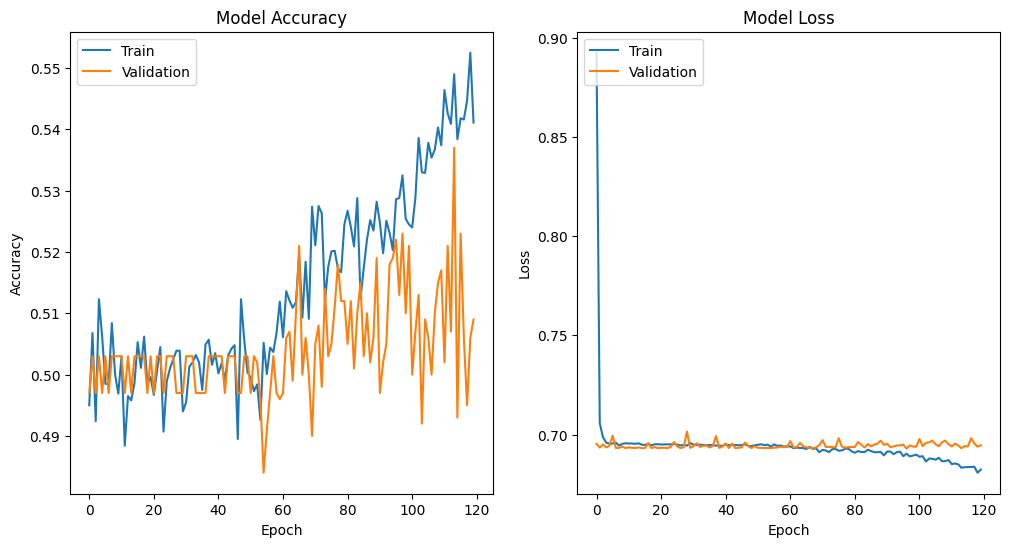

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()